## Load libraries

In [1]:
import os
import urllib
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import math
from numpy.random import uniform, binomial, normal


import torch
import torch.utils.data
import torch.utils.data as data
from torch.optim.optimizer import Optimizer
from torch.autograd import Variable
from torch.nn.functional import softplus
from torch.distributions import kl_divergence
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
from torch.distributions import kl_divergence
import torch.backends.cudnn as cudnn
from torch.distributions.normal import Normal
import torch.utils.data
from torchvision.utils import make_grid, save_image
from torch.nn import Module
from torchvision import datasets, transforms






## Utils

In [2]:
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

# (used in sub network)
def normal_parse_params(params, min_sigma=1e-3):
    """
    Take a Tensor (e. g. neural network output) and return
    torch.distributions.Normal distribution.
    This Normal distribution is component-wise independent,
    and its dimensionality depends on the input shape.
    First half of channels is mean of the distribution,
    the softplus of the second half is std (sigma), so there is
    no restrictions on the input tensor.
    min_sigma is the minimal value of sigma. I. e. if the above
    softplus is less than min_sigma, then sigma is clipped
    from below with value min_sigma. This regularization
    is required for the numerical stability and may be considered
    as a neural network architecture choice without any change
    to the probabilistic model.
    """
    n = params.shape[0]
    d = params.shape[1]
    mu = params[:, :d // 2]
    sigma_params = params[:, d // 2:]
    sigma = softplus(sigma_params)
    sigma = sigma.clamp(min=min_sigma)
    distr = Normal(mu, sigma)
    return distr

## (used in the next function)
def torch_onehot(y, Nclass):
    if y.is_cuda:
        y = y.type(torch.cuda.LongTensor)
    else:
        y = y.type(torch.LongTensor)
    y_onehot = torch.zeros((y.shape[0], Nclass)).type(y.type())
    # In your for loop
    y_onehot.scatter_(1, y.unsqueeze(1), 1)
    return y_onehot

## (used in the fit of the main network)
def gauss_cat_to_flat(x, input_dim_vec):
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output.append(x[:, idx].unsqueeze(1))
        elif dim > 1:
            oh_vec = torch_onehot(x[:, idx], dim).type(x.type())
            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return torch.cat(output, dim=1)

## (also used in the fit of the main network)
def flat_to_gauss_cat(x, input_dim_vec):
    output = []
    cum_dims = 0
    for idx, dims in enumerate(input_dim_vec):
        if dims == 1:
            output.append(x[:, cum_dims].unsqueeze(1))
            cum_dims += 1

        elif dims > 1:
            output.append(x[:, cum_dims:cum_dims + dims].max(dim=1)[1].type(x.type()).unsqueeze(1))
            cum_dims += dims

        else:
            raise ValueError('Error, invalid dimension value')

    return torch.cat(output, dim=1)

def gauss_cat_to_flat_mask(x, input_dim_vec):
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output.append(x[:, idx].unsqueeze(1))
        elif dim > 1:
            oh_vec = x.new_ones(x.shape[0], dim) * x[:, idx].unsqueeze(1)
            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return torch.cat(output, dim=1)

## (also used in the fit of the main network)
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)
        if not v.is_cuda and cuda:
            v = v.cuda()
        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)
        out.append(v)
    return out


# Datafeed function which does something, seems to just be a class for the data?
class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train=None, transform=None):
        self.data = x_train
        self.targets = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.targets is not None:
            return img, self.targets[index]
        else:
            return img

    def __len__(self):
        return len(self.data)

## Skip Connection

In [3]:

#"""
class SkipConnection(nn.Module):

    #Skip-connection over the sequence of layers in the constructor.
    #The module passes input data sequentially through these layers
    #and then adds original data to the result.

    def __init__(self, *args):
        super(SkipConnection, self).__init__()
        self.inner_net = nn.Sequential(*args)

    def forward(self, input):
        return input + self.inner_net(input)
#"""
def preact_leaky_MLPBlock(width):
    return SkipConnection(
        nn.LeakyReLU(),
        nn.BatchNorm1d(num_features=width),
        nn.Linear(width, width),
        )


## Fully connected neural networks

In [4]:
# FC Networks

#Non-leaky (not used)
"""
class MLP_prior_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_prior_net, self).__init__()
        # input layer
        proposal_layers = [nn.Linear(input_dim*2, width), nn.ReLU(), nn.BatchNorm1d(num_features=width)]
        # body
        for i in range(depth-1):
            proposal_layers.append(MLPBlock(width))
        # output layer
        proposal_layers.append(
            nn.Linear(width, latent_dim * 2)
        )

        self.block = nn.Sequential(*proposal_layers)

    def forward(self, x):
        return self.block(x)


class MLP_recognition_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_recognition_net, self).__init__()
        # input layer
        proposal_layers = [nn.Linear(input_dim, width), nn.ReLU(), nn.BatchNorm1d(num_features=width)]
        # body
        for i in range(depth-1):
            proposal_layers.append(MLPBlock(width))
        # output layer
        proposal_layers.append(
            nn.Linear(width, latent_dim * 2)
        )

        self.block = nn.Sequential(*proposal_layers)

    def forward(self, x):
        return self.block(x)


class MLP_generator_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_generator_net, self).__init__()
        # input layer
        generative_layers = [nn.Linear(latent_dim, width), nn.LeakyReLU(), nn.BatchNorm1d(num_features=width)]
        # body
        for i in range(depth-1):
            generative_layers.append(
                # skip-connection from prior network to generative network
                leaky_MLPBlock(width))
        # output layer
        generative_layers.extend([
            nn.Linear(width,
                      input_dim),
        ])
        self.block = nn.Sequential(*generative_layers)

    def forward(self, x):
        return self.block(x)
"""
## Fully linear residual path preact models

#Prior net
class MLP_preact_prior_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_preact_prior_net, self).__init__()
        # input layer
        proposal_layers = [nn.Linear(input_dim*2, width)]
        # body
        for i in range(depth-1):
            proposal_layers.append(preact_leaky_MLPBlock(width))
        # output layer
        proposal_layers.extend([nn.LeakyReLU(), nn.BatchNorm1d(num_features=width), nn.Linear(width, latent_dim * 2)])


        self.block = nn.Sequential(*proposal_layers)

    def forward(self, x):
        return self.block(x)

#Encoder
class MLP_preact_recognition_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_preact_recognition_net, self).__init__()
        # input layer
        proposal_layers = [nn.Linear(input_dim, width)]
        # body
        for i in range(depth-1):
            proposal_layers.append(preact_leaky_MLPBlock(width))
        # output layer
        proposal_layers.extend([nn.LeakyReLU(), nn.BatchNorm1d(num_features=width), nn.Linear(width, latent_dim * 2)])

        self.block = nn.Sequential(*proposal_layers)

    def forward(self, x):
        return self.block(x)

#Decoder
class MLP_preact_generator_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_preact_generator_net, self).__init__()
        # input layer
        generative_layers = [nn.Linear(latent_dim, width)]
        # body
        for i in range(depth-1):
            generative_layers.append(
                # skip-connection from prior network to generative network
                preact_leaky_MLPBlock(width))
        # output layer
        generative_layers.extend([
            nn.LeakyReLU(), nn.BatchNorm1d(num_features=width), nn.Linear(width, input_dim),
        ])
        self.block = nn.Sequential(*generative_layers)

    def forward(self, x):
        return self.block(x)

## Functions for the data

In [5]:

# Load the datasets in UCI
def load_UCI(dset_name, splits=10, seed=0, separate_targets=True, save_dir='data/'):
    mkdir(save_dir)

    if dset_name == 'wine':
        if not os.path.isfile(save_dir+'winequality-red.csv'):
            urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                               filename=save_dir+'winequality-red.csv')
        data = pd.read_csv(save_dir+'winequality-red.csv', header=1, delimiter=';').values
        y_idx = [-1]

    elif dset_name == 'default_credit':
        if not os.path.isfile(save_dir + 'default of credit card clients.xls'):
            urllib.request.urlretrieve(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                filename=save_dir + 'default of credit card clients.xls')
        data = pd.read_excel(save_dir + 'default of credit card clients.xls', header=[0, 1], index_col=0, # delimiter="\s+"
                             ).values
        y_idx = [-1]  # OK


    else:
        raise Exception('Dataset name doesnt match any known datasets.')

    np.random.seed(seed)
    data = data[np.random.permutation(np.arange(len(data)))]

    kf = KFold(n_splits=splits)
    for j, (train_index, test_index) in enumerate(kf.split(data)):

        # Not sure what separate targets is
        if separate_targets:
            x_idx = list(range(data.shape[1]))
            for e in y_idx:
                x_idx.remove(x_idx[e])

            x_idx = np.array(x_idx)
            y_idx = np.array(y_idx)
            x_train, y_train = data[train_index, :], data[train_index, :]
            x_train, y_train = x_train[:, x_idx], y_train[:, y_idx]
            x_test, y_test = data[test_index, :], data[test_index, :]
            x_test, y_test = x_test[:, x_idx], y_test[:, y_idx]

            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)
            y_means, y_stds = y_train.mean(axis=0), y_train.std(axis=0)

            y_stds[y_stds < 1e-10] = 1
            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            y_train = ((y_train - y_means) / y_stds).astype(np.float32)

            x_test = ((x_test - x_means) / x_stds).astype(np.float32)
            y_test = ((y_test - y_means) / y_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds

        else:
            x_train, x_test = data[train_index, :], data[test_index, :]
            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)

            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            x_test = ((x_test - x_means) / x_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds

def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

# Not sure why this is needed
def unnormalise_cat_vars(x, x_means, x_stds, input_dim_vec):
    input_dim_vec = np.array(input_dim_vec)
    unnorm_x = np.multiply(x, x_stds) + x_means

    fixed_unnorm = unnorm_x.round()
    fixed_unnorm -= fixed_unnorm.min(axis=0).reshape([1, fixed_unnorm.shape[1]])  # this sets all mins to 0
    for idx, dims in enumerate(input_dim_vec):
        if dims > 1:
            vec = fixed_unnorm[:, idx]
            vec[vec > dims - 1] = dims - 1
            fixed_unnorm[:, idx] = vec

    x[:, input_dim_vec > 1] = fixed_unnorm[:, input_dim_vec > 1]
    return x


In [6]:
names = ['wine', 'default_credit', 'compas', 'lsat']
widths = [350, 350, 350, 350] # Bigger than VAE because the task of modelling all conditionals is more complex
depths = [3, 3, 3, 3] # We go deeper because we are using residual models
latent_dims = [6, 8, 4, 4]
under_latent_dims = [6, 8, 4, 4] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]
under_latent_dims2 = [4, 6, 3, 3] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]

dname = 'default_credit'
print(dname)

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../data/')

default_credit


In [7]:
from __future__ import division
import datetime
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from random import seed
#from .UCI_loader import unnormalise_cat_vars


# TODO return mean and std for variables + train test split

"""
def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        try:
            response = urllib2.urlopen(addr)
        except:
            response = urllib3.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "w")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."
"""

def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        
        response = urllib.request.urlopen(addr)

        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."

def get_my_COMPAS(rseed=0, separate_test=True, test_ratio=0.2, save_dir='../data/'):
    """
        The adult dataset can be obtained from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
        The code will look for the data file in the present directory, if it is not found, it will download them from GitHub.
    """

    SEED = rseed
    seed(SEED)
    np.random.seed(SEED)

    their_FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]
    FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "c_charge_degree", "is_recid", "priors_count",
                               "time_served"]  # features to be used for classification
    CONT_VARIABLES = ["priors_count",
                      "time_served"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "two_year_recid"  # the decision variable


    COMPAS_INPUT_FILE = save_dir + "compas-scores-two-years.csv"
    check_data_file(COMPAS_INPUT_FILE)

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df = df.dropna(subset=["days_b_screening_arrest"])  # dropping missing vals

    # convert to np array
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])

    dates_in = data['c_jail_in']
    dates_out = data['c_jail_out']
    # this measures time in Jail
    time_served = []
    for i in range(len(dates_in)):
        di = datetime.datetime.strptime(dates_in[i], '%Y-%m-%d %H:%M:%S')
        do = datetime.datetime.strptime(dates_out[i], '%Y-%m-%d %H:%M:%S')
        time_served.append((do - di).days)
    time_served = np.array(time_served)
    time_served[time_served < 0] = 0
    data["time_served"] = time_served

    """ Filtering the data """

    # These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
    # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    idx = np.logical_and(data["days_b_screening_arrest"] <= 30, data["days_b_screening_arrest"] >= -30)

    # We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    idx = np.logical_and(idx, data["is_recid"] != -1)

    # In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    idx = np.logical_and(idx, data["c_charge_degree"] != "O")  # F: felony, M: misconduct

    # We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
    idx = np.logical_and(idx, data["score_text"] != "NA")

    # select the examples that satisfy this criteria
    for k in data.keys():
        data[k] = data[k][idx]

    y = data[CLASS_FEATURE]
    """ Feature normalization and one hot encoding """

    print
    "\nNumber of people recidivating within two years"
    print
    pd.Series(y).value_counts()
    print
    "\n"

    X = []  # empty array with num rows same as num examples, will hstack the features to it
    X_dims = []

    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            # vals = preprocessing.scale(vals, axis=0, with_mean=True, with_std=True)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            X_dims.append(1)

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
            enc.fit(vals.reshape(-1, 1))
            vals = enc.transform(vals.reshape(-1, 1)).todense()
            X_dims += [vals.shape[1]]*vals.shape[1]

        # add to learnable features
        X.append(vals)

        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in enc.categories_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    X = np.array(np.concatenate(list(X), axis=1))
    X_dims = np.array(X_dims)

    if separate_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rseed, shuffle=True)

        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
        x_means[X_dims>1] = 0
        x_stds[X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X_train - x_means) / x_stds).astype(np.float32)
        x_test = ((X_test - x_means) / x_stds).astype(np.float32)

        return x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims
    else:
        x_means, x_stds = X.mean(axis=0), X.std(axis=0)
        print(X_dims.shape, x_means.shape)
        x_means[:,X_dims>1] = 0
        x_stds[:,X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X - x_means) / x_stds).astype(np.float32)

        return x_train, x_means, x_stds, y, feature_names, X_dims


def join_compas_targets(x_train, x_test, y_train, y_test, X_dims):
    # output from get method is onehot so we need to flatten and append 2
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    input_dim_vec = np.append(input_dim_vec, 2)
    enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
    enc.fit(y_train.reshape(-1, 1))

    vals_train = np.array(enc.transform(y_train.reshape(-1, 1)).todense()).astype(np.float32)
    vals_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()).astype(np.float32)

    x_train = np.concatenate([x_train, vals_train], axis=1)
    x_test = np.concatenate([x_test, vals_test], axis=1)
    return x_train, x_test, input_dim_vec


def X_dims_to_input_dim_vec(X_dims):
    """This is for our cat_Gauss VAE model"""
    input_dim_vec = []
    i = 0
    while i < len(X_dims):
        input_dim_vec.append(X_dims[i])
        i += X_dims[i]
    return np.array(input_dim_vec)

#"""
def input_dim_vec_to_X_dims(input_dim_vec):
    # This is for our cat_Gauss VAE model
    X_dims = []
    for i in input_dim_vec:
        for ii in range(i):
            X_dims.append(i)
    return np.array(X_dims)
#"""

# Create datafeed for torch

In [8]:
trainset = Datafeed(x_train, x_train, transform=None) 
valset = Datafeed(x_test, x_train, transform=None)

save_dir = '../saves/fc_preact_VAEAC_NEW_' + dname


# Masker for the VAEAC training

In [9]:
class top_masker:
    """
    Returned mask is sampled from component-wise independent Bernoulli
    distribution with probability of component to be unobserved p.
    Such mask induces the type of missingness which is called
    in literature "missing completely at random" (MCAR).
    If some value in batch is missed, it automatically becomes unobserved.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, batch):
        pp = uniform(low=0.0, high=self.p, size=batch.shape[0])
        pp = np.expand_dims(pp, axis=1)
        pp = np.repeat(pp, batch.shape[1], axis=1)
        nan_mask = torch.isnan(batch).float()  # missed values
#         bernoulli_mask_numpy = np.random.choice(2, size=batch.shape,
#                                                 p=[1 - pp, pp])
        bernoulli_mask_numpy = binomial(1, pp, size=None)
#         print(bernoulli_mask_numpy.shape)
        bernoulli_mask = torch.from_numpy(bernoulli_mask_numpy).float()
        mask = torch.max(bernoulli_mask, nan_mask)  # logical or
        return mask
    
masker = top_masker(p=1)



# rms cat loglike (only for categorical data)

In [10]:
class rms_cat_loglike(nn.Module):

    def __init__(self, input_dim_vec, reduction='none'):
        super(rms_cat_loglike, self).__init__()
        self.reduction = reduction
        self.input_dim_vec = input_dim_vec
        self.mse = MSELoss(reduction='none')  # takes(input, target)
        self.ce = CrossEntropyLoss(reduction='none')

    def forward(self, x, y):

        log_prob_vec = []
        cum_dims = 0
        for idx, dims in enumerate(self.input_dim_vec):
            if dims == 1:
                # Gaussian_case
                log_prob_vec.append(-self.mse(x[:, cum_dims], y[:, idx]).unsqueeze(1))
                cum_dims += 1

            elif dims > 1:
                if x.shape[1] == y.shape[1]:
                    raise Exception('Input and target seem to be in flat format. Need integer cat targets.')
                                
                if y.is_cuda:
                    tget = y[:, idx].type(torch.cuda.LongTensor)
                else:
                    tget = y[:, idx].type(torch.LongTensor)

                log_prob_vec.append(-self.ce(x[:, cum_dims:cum_dims + dims], tget).unsqueeze(1))
                cum_dims += dims

            else:
                raise ValueError('Error, invalid dimension value')

        log_prob_vec = torch.cat(log_prob_vec, dim=1)

        if self.reduction == 'none':
            return log_prob_vec
        elif self.reduction == 'sum':
            return log_prob_vec.sum()
        elif self.reduction == 'average':
            return log_prob_vec.mean()

# Gaussian log likelihood (For datasets with continous with or without categorical data)

In [11]:

class GaussianLoglike(Module):
    """
    Compute reconstruction log probability of groundtruth given
    a tensor of Gaussian distribution parameters and a mask.
    Gaussian distribution parameters are output of a neural network
    without any restrictions, the minimal sigma value is clipped
    from below to min_sigma (default: 1e-2) in order not to overfit
    network on some exact pixels.
    The first half of channels corresponds to mean, the second half
    corresponds to std. See normal_parse_parameters for more info.
    This layer doesn't work with NaNs in the data, it is used for
    inpainting. Roughly speaking, this loss is similar to L2 loss.
    Returns a vector of log probabilities for each object of the batch.
    """
    def __init__(self, min_sigma=1e-2):
        super(GaussianLoglike, self).__init__()
        self.min_sigma = min_sigma

    def forward(self, distr_params, groundtruth, mask=None):
        distr = normal_parse_params(distr_params, self.min_sigma)
        if mask is not None:
            log_probs = distr.log_prob(groundtruth) * mask
        else:
            log_probs = distr.log_prob(groundtruth)
        return log_probs.view(groundtruth.shape[0], -1).sum(-1)

# Rectified Adam Optimizer

In [12]:
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (
                                        N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# Base Network

In [13]:
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % (self.lr, epoch))
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

# Sub network

In [14]:
class VAEAC_gauss(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim, pred_sig=True):
        super(VAEAC_gauss, self).__init__()
        self.latent_dim = latent_dim
        self.recognition_net = MLP_preact_recognition_net(input_dim, width, depth, latent_dim)
        self.prior_net = MLP_preact_prior_net(input_dim, width, depth, latent_dim)
        if pred_sig:
            self.generator_net = MLP_preact_generator_net(2*input_dim, width, depth, latent_dim)
            self.rec_loglike = GaussianLoglike(min_sigma=1e-2)
        else:
            self.generator_net = MLP_preact_generator_net(input_dim, width, depth, latent_dim)
            self.m_rec_loglike = MSELoss(reduction='none')
        self.pred_sig = pred_sig
        self.sigma_mu = 1e4
        self.sigma_sigma = 1e-4


    @staticmethod
    def apply_mask(x, mask):
        """Positive bits in mask are set to 0 in x (observed)"""
        observed = x.clone()  # torch.tensor(x)
        observed[mask.bool()] = 0
        return observed

    def recognition_encode(self, x):
        approx_post_params = self.recognition_net(x)
        approx_post = normal_parse_params(approx_post_params, 1e-3)
        return approx_post

    def prior_encode(self, x, mask):
        x = self.apply_mask(x, mask)
        x = torch.cat([x, mask], 1)
        prior_params = self.prior_net(x)
        prior = normal_parse_params(prior_params, 1e-3)
        return prior

    def decode(self, z_sample):
        rec_params = self.generator_net(z_sample)
        return rec_params

    def reg_cost(self, prior):
        num_objects = prior.mean.shape[0]
        mu = prior.mean.view(num_objects, -1)
        sigma = prior.scale.view(num_objects, -1)
        mu_regularizer = -(mu ** 2).sum(-1) / 2 / (self.sigma_mu ** 2)
        sigma_regularizer = (sigma.log() - sigma).sum(-1) * self.sigma_sigma
        return mu_regularizer + sigma_regularizer

    def vlb(self, prior, approx_post, x, rec_params):
        if self.pred_sig:
            rec = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        else:
            rec = -self.m_rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        prior_regularization = self.reg_cost(prior).view(x.shape[0], -1).sum(-1)
        kl = kl_divergence(approx_post, prior).view(x.shape[0], -1).sum(-1)
        return rec - kl + prior_regularization

    def iwlb(self, prior, approx_post, x, K=50):
        estimates = []
        for i in range(K):
            latent = approx_post.rsample()
            rec_params = self.decode(latent)
            if self.pred_sig:
                rec_loglike = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
            else:
                rec_loglike = -self.m_rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)

            prior_log_prob = prior.log_prob(latent)
            prior_log_prob = prior_log_prob.view(x.shape[0], -1)
            prior_log_prob = prior_log_prob.sum(-1)

            proposal_log_prob = approx_post.log_prob(latent)
            proposal_log_prob = proposal_log_prob.view(x.shape[0], -1)
            proposal_log_prob = proposal_log_prob.sum(-1)

            estimate = rec_loglike + prior_log_prob - proposal_log_prob
            estimates.append(estimate[:, None])

        return torch.logsumexp(torch.cat(estimates, 1), 1) - np.log(K)

# Main Network

In [15]:
# Main Network
class VAEAC_gauss_net(BaseNet):
    def __init__(self, input_dim, width, depth, latent_dim, pred_sig=True, lr=1e-3, cuda=True):
        super(VAEAC_gauss_net, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.cuda = cuda

        self.input_dim = input_dim
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr
        self.pred_sig = pred_sig

        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.schedule = None

        self.vlb_scale = 1 / input_dim  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAEAC_gauss(self.input_dim, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = RAdam(self.model.parameters(), lr=self.lr) # torch.optim.Adam

    def fit(self, x, mask):
        self.set_mode_train(train=True)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        self.optimizer.zero_grad()

        prior = self.model.prior_encode(x, mask)
        approx_post = self.model.recognition_encode(x)
        z_sample = approx_post.rsample()
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval(self, x, mask, sample=False):
        self.set_mode_train(train=False)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)

        approx_post = self.model.recognition_encode(x)
        if sample:
            z_sample = approx_post.sample()
        else:
            z_sample = approx_post.loc
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval_iw(self, x, mask, k=50):
        self.set_mode_train(train=False)
        x, mask = to_variable(var=(x, mask), cuda=self.cuda)

        prior = self.model.prior_encode(x, mask)
        approx_post = self.model.recognition_encode(x)

        iw_lb = self.model.iwlb(prior, approx_post, x, k)
        return iw_lb.mean().item()

    def get_prior(self, x, mask):
        self.set_mode_train(train=False)
        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        return prior

    def get_post(self, x):
        self.set_mode_train(train=False)
        x, = to_variable(var=(x,), cuda=self.cuda)
        approx_post = self.model.recognition_encode(x)
        return approx_post

    def inpaint(self, x, mask, Nsample=1, z_mean=False):
        self.set_mode_train(train=False)
        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        out = []
        for i in range(Nsample):
            if z_mean:
                z_sample = prior.loc.data
            else:
                z_sample = prior.sample()
            rec_params = self.model.decode(z_sample)
            out.append(rec_params.data)
        out = torch.stack(out, dim=0)

        if self.pred_sig:
            return [normal_parse_params(out[i], 1e-2) for i in range(Nsample)]
        else:
            return out

    def regenerate(self, z, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)
        if self.pred_sig:
            return normal_parse_params(out, 1e-2)
        else:
            return out.data
class VAEAC_gauss_cat(nn.Module):
    def __init__(self, input_dim_vec, width, depth, latent_dim, pred_sig=True):
        super(VAEAC_gauss_cat, self).__init__()

        self.input_dim = 0
        self.input_dim_vec = input_dim_vec
        for e in self.input_dim_vec:
            self.input_dim += e

        self.latent_dim = latent_dim
        self.recognition_net = MLP_preact_recognition_net(self.input_dim, width, depth, latent_dim)
        self.prior_net = MLP_preact_prior_net(self.input_dim, width, depth, latent_dim)
        if pred_sig:
            raise Exception('Not yet implemented')
        else:
            self.generator_net = MLP_preact_generator_net(self.input_dim, width, depth, latent_dim)
            self.rec_loglike = rms_cat_loglike(self.input_dim_vec, reduction='none')
        self.pred_sig = pred_sig
        self.sigma_mu = 1e4
        self.sigma_sigma = 1e-4


    @staticmethod
    def apply_mask(x, mask):
        """Positive bits in mask are set to 0 in x (observed)"""
        observed = x.clone()  # torch.tensor(x)
        observed[mask.bool()] = 0
        return observed

    def recognition_encode(self, x):
        """Works with flattened representATION"""
        approx_post_params = self.recognition_net(x)
        approx_post = normal_parse_params(approx_post_params, 1e-3)
        return approx_post

    def prior_encode(self, x, mask):
        """Works with flattened representATION"""
        x = self.apply_mask(x, mask)
        x = torch.cat([x, mask], 1)
        prior_params = self.prior_net(x)
        prior = normal_parse_params(prior_params, 1e-3)
        return prior

    def decode(self, z_sample):
        rec_params = self.generator_net(z_sample)
        return rec_params

    def reg_cost(self, prior):
        num_objects = prior.mean.shape[0]
        mu = prior.mean.view(num_objects, -1)
        sigma = prior.scale.view(num_objects, -1)
        mu_regularizer = -(mu ** 2).sum(-1) / 2 / (self.sigma_mu ** 2)
        sigma_regularizer = (sigma.log() - sigma).sum(-1) * self.sigma_sigma
        return mu_regularizer + sigma_regularizer

    def vlb(self, prior, approx_post, x, rec_params):
        if self.pred_sig:
            raise Exception('Not yet imeplemented')
        else:
            rec = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        prior_regularization = self.reg_cost(prior).view(x.shape[0], -1).sum(-1)
        kl = kl_divergence(approx_post, prior).view(x.shape[0], -1).sum(-1)
        return rec - kl + prior_regularization

    def iwlb(self, prior, approx_post, x, K=50):
        estimates = []
        for i in range(K):
            latent = approx_post.rsample()
            rec_params = self.decode(latent)
            if self.pred_sig:
                raise Exception('Not yet imeplemented')
            else:
                rec_loglike = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)

            prior_log_prob = prior.log_prob(latent)
            prior_log_prob = prior_log_prob.view(x.shape[0], -1)
            prior_log_prob = prior_log_prob.sum(-1)

            proposal_log_prob = approx_post.log_prob(latent)
            proposal_log_prob = proposal_log_prob.view(x.shape[0], -1)
            proposal_log_prob = proposal_log_prob.sum(-1)

            estimate = rec_loglike + prior_log_prob - proposal_log_prob
            estimates.append(estimate[:, None])

        return torch.logsumexp(torch.cat(estimates, 1), 1) - np.log(K)

In [16]:


class VAEAC_gauss_cat_net(BaseNet):
    def __init__(self, input_dim_vec, width, depth, latent_dim, pred_sig=False, lr=1e-3, cuda=True, flatten=True):
        super(VAEAC_gauss_cat_net, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.cuda = cuda

        self.input_dim = 0
        self.input_dim_vec = input_dim_vec
        for e in self.input_dim_vec:
            self.input_dim += e
        self.flatten = flatten
        if not self.flatten:
            pass
            # raise Exception('Error calculation not supported without flattening')

        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr
        self.pred_sig = pred_sig

        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.schedule = None

        self.vlb_scale = 1 / len(self.input_dim_vec)  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAEAC_gauss_cat(self.input_dim_vec, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = RAdam(self.model.parameters(), lr=self.lr)  # torch.optim.Adam

    def fit(self, x, mask):
        self.set_mode_train(train=True)
        
        #print("bef x: ", x.shape)
        if self.flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        
        else:
            x_flat = x # X already flattened
            x = flat_to_gauss_cat(x, self.input_dim_vec) # unflattened x (used for loss computation)
        #print("aft x: ", x.shape)
        x_flat, x, mask = to_variable(var=(x_flat, x, mask), cuda=self.cuda)
        self.optimizer.zero_grad()

        prior = self.model.prior_encode(x_flat, mask)
        approx_post = self.model.recognition_encode(x_flat)
        z_sample = approx_post.rsample()
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval(self, x, mask, sample=False):
        self.set_mode_train(train=False)

        if self.flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)

        x_flat, x, mask = to_variable(var=(x_flat, x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x_flat, mask)

        approx_post = self.model.recognition_encode(x_flat)
        if sample:
            z_sample = approx_post.sample()
        else:
            z_sample = approx_post.loc
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(prior, approx_post, x, rec_params)

        if self.pred_sig:
            rec_return = normal_parse_params(rec_params, 1e-3)
        else:
            rec_return = rec_params
        return vlb.mean().item(), rec_return

    def eval_iw(self, x, mask, k=50):
        self.set_mode_train(train=False)

        if self.flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)


        x_flat, x, mask = to_variable(var=(x_flat, x, mask), cuda=self.cuda)

        prior = self.model.prior_encode(x, mask)
        approx_post = self.model.recognition_encode(x_flat)

        iw_lb = self.model.iwlb(prior, approx_post, x, k)
        return iw_lb.mean().item()

    def get_prior(self, x, mask, flatten=None):
        self.set_mode_train(train=False)
        if flatten is None:
            flatten = self.flatten
        if flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x = gauss_cat_to_flat(x, self.input_dim_vec)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        return prior

    def get_post(self, x, flatten=None):
        self.set_mode_train(train=False)
        if flatten is None:
            flatten = self.flatten
        if flatten:
            x = gauss_cat_to_flat(x, self.input_dim_vec)

        x, = to_variable(var=(x,), cuda=self.cuda)
        approx_post = self.model.recognition_encode(x)
        return approx_post

    def inpaint(self, x, mask, Nsample=1, z_mean=False, flatten=False, unflatten=False, cat_probs=False):
        self.set_mode_train(train=False)

        if flatten:
            mask = gauss_cat_to_flat_mask(mask, self.input_dim_vec)
            x = gauss_cat_to_flat(x, self.input_dim_vec)

        x, mask = to_variable(var=(x, mask), cuda=self.cuda)
        prior = self.model.prior_encode(x, mask)
        out = []
        for i in range(Nsample):
            if z_mean:
                z_sample = prior.loc.data
            else:
                z_sample = prior.sample()
            rec_params = self.model.decode(z_sample)
            out.append(rec_params.data)
        out = torch.stack(out, dim=0)

        if self.pred_sig:
            raise Exception('Not yet implemented')
        else:
            dim0 = out.shape[0]
            dim1 = out.shape[1]
            out = out.view(dim0*dim1, -1)
            if unflatten:
                out = flat_to_gauss_cat(out, self.input_dim_vec)
            else:
                out = selective_softmax(out, self.input_dim_vec, grad=False, cat_probs=cat_probs)
            out = out.view(dim0, dim1, -1)
            return out.data

    def regenerate(self, z, grad=False, unflatten=False):
        self.set_mode_train(train=False)
        if unflatten and grad:
            raise Exception('flatten and grad options are not compatible')
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)
        if self.pred_sig:
            raise Exception('Not yet implemented')
        else:
            if unflatten:
                out = flat_to_gauss_cat(out, self.input_dim_vec)
            else:
                out = selective_softmax(out, self.input_dim_vec, grad=grad)
            return out.data

## Training function

In [17]:
def train_VAEAC(net, masker, name, batch_size, nb_epochs, trainset, valset, cuda,
                flat_ims=False, train_plot=False, Nclass=None, early_stop=None, script_mode=False):

    models_dir = name + '_models'
    results_dir = name + '_results'
    mkdir(models_dir)
    mkdir(results_dir)

    if cuda:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                                  num_workers=0)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                                num_workers=0)

    else:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                                  num_workers=0)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                                num_workers=0)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
    cprint('c', '\nNetwork:')

    epoch = 0

    ## ---------------------------------------------------------------------------------------------------------------------
    # train
    cprint('c', '\nTrain:')

    print('  init cost variables:')
    vlb_train = np.zeros(nb_epochs)
    vlb_dev = np.zeros(nb_epochs)
    iwlb_dev = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_epoch = 0

    nb_its_dev = 1
    
    tic0 = time.time()
    for i in range(epoch, nb_epochs):
        net.set_mode_train(True)

        tic = time.time()
        nb_samples = 0
        for x, y in trainloader:

            if flat_ims:
                x = x.view(x.shape[0], -1)
            if Nclass is not None:
                y_oh = torch_onehot(y, Nclass).type(x.type())
                x = torch.cat([x, y_oh], 1)

            mask = masker(x)
            cost, _ = net.fit(x, mask)

            vlb_train[i] += cost * len(x)
            nb_samples += len(x)

        vlb_train[i] /= nb_samples

        toc = time.time()

        # ---- print
        print("it %d/%d, vlb %f, " % (i, nb_epochs, vlb_train[i]), end="")
        cprint('r', '   time: %f seconds\n' % (toc - tic))
        net.update_lr(i)

        # ---- dev
        if i % nb_its_dev == 0:
            nb_samples = 0
            for j, (x, y) in enumerate(valloader):

                if flat_ims:
                    x = x.view(x.shape[0], -1)
                if Nclass is not None:
                    y_oh = torch_onehot(y, Nclass).type(x.type())
                    x = torch.cat([x, y_oh], 1)

                mask = masker(x)
                cost, rec_mean = net.eval(x, mask)
                # iwlb = net.eval_iw(x, mask, 25)

                vlb_dev[i] += cost * len(x)
                # iwlb_dev[i] += iwlb
                nb_samples += len(x)

            vlb_dev[i] /= nb_samples
            # iwlb_dev[i] /= nb_samples

            cprint('g', '    vlb %f (%f)\n' % (vlb_dev[i], best_vlb))

            if train_plot:
                xm = net.model.apply_mask(x, mask)
                
                xr = x.cpu()
                rec_inpaint = net.inpaint(xm, mask)
                try:
                    o = rec_mean.cpu()
                    rec_inpaint = rec_inpaint[0].cpu()
                except:
                    o = rec_mean.loc.cpu()
                    rec_inpaint = rec_inpaint[0].loc.cpu()

                if Nclass is not None:
                    xm = xm[:, :-Nclass]
                    rec_inpaint = rec_inpaint[:, :-Nclass]
                    xr = xr[:, :-Nclass]
                    o = o[:, :-Nclass]

                if len(x.shape) == 2:
                    side = int(np.sqrt(xm.shape[1]))
                    xm = xm.view(-1, 1, side, side).data
                    rec_inpaint = rec_inpaint.view(-1, 1, side, side).data
                    xr = xr.view(-1, 1, side, side).data
                    o = o.view(-1, 1, side, side).data

                import matplotlib.pyplot as plt
                plt.figure()
                dd = make_grid(torch.cat([xr[:10], o[:10]]), nrow=10).numpy()
                plt.imshow(np.transpose(dd, (1, 2, 0)), interpolation='nearest')
                plt.title('reconstruct')
                if script_mode:
                    plt.savefig(results_dir + '/rec%d.png' % i)
                else:
                    plt.show()

                import matplotlib.pyplot as plt
                plt.figure()
                dd = make_grid(torch.cat([xm[:10], rec_inpaint[:10]]), nrow=10).numpy()
                plt.imshow(np.transpose(dd, (1, 2, 0)), interpolation='nearest')
                plt.title('inpaint')
                if script_mode:
                    plt.savefig(results_dir + '/inp%d.png' % i)
                else:
                    plt.show()

        if vlb_dev[i] > best_vlb:
            best_vlb = vlb_dev[i]
            best_epoch = i
            net.save(models_dir + '/theta_best.dat')

        if early_stop is not None and (i - best_epoch) > early_stop:
            break

   
    net.save(models_dir + '/theta_last.dat')
    toc0 = time.time()
    runtime_per_it = (toc0 - tic0) / float(nb_epochs)
    cprint('r', '   average time: %f seconds\n' % runtime_per_it)

    ## ---------------------------------------------------------------------------------------------------------------------
    # results
    """
    cprint('c', '\nRESULTS:')
    nb_parameters = net.get_nb_parameters()
    best_cost_dev = np.max(vlb_dev)
    # best_iw_dev = np.max(iwlb_dev)
    best_cost_train = np.max(vlb_train)

    print('  best_vlb_dev: %f' % best_cost_dev)
    # print('  best_iwlb_dev: %f' % best_iw_dev)
    print('  best_vlb_train: %f' % best_cost_train)
    print('  nb_parameters: %d (%s)\n' % (nb_parameters, humansize(nb_parameters)))

    ## ---------------------------------------------------------------------------------------------------------------------
    # fig cost vs its
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(np.clip(vlb_train, -1000, 1000), 'r')
    plt.plot(np.clip(vlb_dev[::nb_its_dev], -1000, 1000), 'b')
    plt.legend(['cost_train', 'cost_dev'])
    plt.ylabel('vlb')
    plt.xlabel('it')
    plt.grid(True)
    plt.savefig(results_dir+'/train_cost.png')

    # plt.figure()
    # plt.plot(np.clip(iwlb_dev[::nb_its_dev], -1000, 1000), 'b')
    # plt.ylabel('dev iwlb')
    # plt.xlabel('it')
    # plt.grid(True)
    # plt.savefig(results_dir + '/train_iwlb.png')
    if train_plot:
        plt.show()
    """
    return vlb_train, vlb_dev, best_epoch, best_vlb, i


## COMPAS

In [18]:
masker = top_masker(p=1)

x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')
x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)
print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)

dname = 'compas'
print(dname)

trainset = Datafeed(x_train, x_train, transform=None)
valset = Datafeed(x_test, x_test, transform=None)

save_dir = './torch_vlb/fc_preact_VAEAC_NEW_' + dname

width = widths[names.index(dname)]
depth = depths[names.index(dname)] # number of hidden layers
latent_dim = latent_dims[names.index(dname)]

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

cuda = torch.cuda.is_available()

net = VAEAC_gauss_cat_net(input_dim_vec, width, depth, latent_dim, pred_sig=False, lr=lr,
                          cuda=cuda, flatten=False)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(net, masker, save_dir, batch_size, nb_epochs, trainset, valset, cuda,
                     flat_ims=False, train_plot=False, Nclass=None, early_stop=early_stop)

Compas (5554, 19) (618, 19)
[3 6 2 2 2 1 1 2]
compas

Net:
VAE_gauss_net
    Total params: 0.78M

Network:

Train:
  init cost variables:


C:\Users\mortimer\AppData\Local\Temp/ipykernel_22248/1070947545.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())
C:\Users\mortimer\AppData\Local\Temp/ipykernel_22248/550312925.py:50: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


it 0/2000, vlb -18.386189,    time: 2.919683 seconds

    vlb -10.611259 (-inf)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 1/2000, vlb -12.882605,    time: 0.745697 seconds

    vlb -11.213885 (-10.611259)

it 2/2000, vlb -10.996987,    time: 0.699239 seconds

    vlb -10.212140 (-10.611259)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 3/2000, vlb -10.062862,    time: 0.744037 seconds

    vlb -9.367107 (-10.212140)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 4/2000, vlb -9.372795,    time: 0.708894 seconds

    vlb -8.290073 (-9.367107)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 5/2000, vlb -8.790879,    time: 0.698157 seconds

    vlb -7.669571 (-8.290073)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 6/2000, vlb -8.312908,    time: 0.890160 seconds

    vlb -7.368272 (-7.669571)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_mode

    vlb -3.106750 (-3.040395)

it 49/2000, vlb -4.171590,    time: 0.678968 seconds

    vlb -3.166676 (-3.040395)

it 50/2000, vlb -4.073566,    time: 0.689266 seconds

    vlb -3.007398 (-3.040395)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 51/2000, vlb -4.092963,    time: 0.741138 seconds

    vlb -3.000216 (-3.007398)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 52/2000, vlb -4.100424,    time: 0.702148 seconds

    vlb -3.114018 (-3.000216)

it 53/2000, vlb -4.014147,    time: 0.700155 seconds

    vlb -3.038027 (-3.000216)

it 54/2000, vlb -3.990794,    time: 0.691779 seconds

    vlb -2.871552 (-3.000216)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 55/2000, vlb -4.041033,    time: 0.744155 seconds

    vlb -3.084946 (-2.871552)

it 56/2000, vlb -3.991604,    time: 0.696799 seconds

    vlb -2.775376 (-2.871552)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 57

    vlb -2.472693 (-2.389194)

it 121/2000, vlb -3.336367,    time: 0.696216 seconds

    vlb -2.496231 (-2.389194)

it 122/2000, vlb -3.324256,    time: 0.681899 seconds

    vlb -2.513239 (-2.389194)

it 123/2000, vlb -3.319148,    time: 0.686744 seconds

    vlb -2.543611 (-2.389194)

it 124/2000, vlb -3.268432,    time: 0.692968 seconds

    vlb -2.544091 (-2.389194)

it 125/2000, vlb -3.279088,    time: 0.684222 seconds

    vlb -2.492832 (-2.389194)

it 126/2000, vlb -3.276651,    time: 0.697798 seconds

    vlb -2.425328 (-2.389194)

it 127/2000, vlb -3.283475,    time: 0.698063 seconds

    vlb -2.442968 (-2.389194)

it 128/2000, vlb -3.276904,    time: 0.696809 seconds

    vlb -2.386448 (-2.389194)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 129/2000, vlb -3.296070,    time: 0.683679 seconds

    vlb -2.481448 (-2.386448)

it 130/2000, vlb -3.295955,    time: 0.715146 seconds

    vlb -2.409304 (-2.386448)

it 131/2000, vlb -3.219111,    time: 0

    vlb -2.334578 (-2.218680)

it 193/2000, vlb -3.096401,    time: 0.696067 seconds

    vlb -2.381440 (-2.218680)

it 194/2000, vlb -3.115523,    time: 0.685194 seconds

    vlb -2.277959 (-2.218680)

it 195/2000, vlb -2.979169,    time: 0.682854 seconds

    vlb -2.339864 (-2.218680)

it 196/2000, vlb -3.053114,    time: 0.697067 seconds

    vlb -2.384498 (-2.218680)

it 197/2000, vlb -3.041884,    time: 0.696657 seconds

    vlb -2.408216 (-2.218680)

it 198/2000, vlb -3.024978,    time: 0.683790 seconds

    vlb -2.320795 (-2.218680)

it 199/2000, vlb -3.076251,    time: 0.695162 seconds

    vlb -2.227119 (-2.218680)

it 200/2000, vlb -3.005144,    time: 0.695918 seconds

    vlb -2.247794 (-2.218680)

it 201/2000, vlb -3.003044,    time: 0.701937 seconds

    vlb -2.211763 (-2.218680)

Writting ./torch_vlb/fc_preact_VAEAC_NEW_compas_models/theta_best.dat

it 202/2000, vlb -3.042872,    time: 0.697391 seconds

    vlb -2.381695 (-2.211763)

it 203/2000, vlb -2.995418,    time: 0

    vlb -2.316104 (-2.109325)

it 269/2000, vlb -2.907237,    time: 0.693359 seconds

    vlb -2.337363 (-2.109325)

it 270/2000, vlb -2.921379,    time: 0.687799 seconds

    vlb -2.266761 (-2.109325)

it 271/2000, vlb -2.865087,    time: 0.681591 seconds

    vlb -2.181430 (-2.109325)

it 272/2000, vlb -2.889970,    time: 0.698650 seconds

    vlb -2.160904 (-2.109325)

it 273/2000, vlb -2.952025,    time: 0.688086 seconds

    vlb -2.185376 (-2.109325)

it 274/2000, vlb -2.901129,    time: 0.720309 seconds

    vlb -2.188873 (-2.109325)

it 275/2000, vlb -2.884046,    time: 0.698159 seconds

    vlb -2.317495 (-2.109325)

it 276/2000, vlb -2.891608,    time: 0.685686 seconds

    vlb -2.361709 (-2.109325)

it 277/2000, vlb -2.918211,    time: 0.698639 seconds

    vlb -2.259400 (-2.109325)

it 278/2000, vlb -2.888765,    time: 0.694111 seconds

    vlb -2.241178 (-2.109325)

it 279/2000, vlb -2.888428,    time: 0.698891 seconds

    vlb -2.236273 (-2.109325)

it 280/2000, vlb -2.856

it 346/2000, vlb -2.828385,    time: 0.720204 seconds

    vlb -2.111417 (-2.057936)

it 347/2000, vlb -2.807245,    time: 0.730203 seconds

    vlb -2.230100 (-2.057936)

it 348/2000, vlb -2.816463,    time: 0.691174 seconds

    vlb -2.284725 (-2.057936)

it 349/2000, vlb -2.788471,    time: 0.702287 seconds

    vlb -2.311867 (-2.057936)

it 350/2000, vlb -2.852033,    time: 0.696545 seconds

    vlb -2.281101 (-2.057936)

it 351/2000, vlb -2.823932,    time: 0.697653 seconds

    vlb -2.264631 (-2.057936)

it 352/2000, vlb -2.789295,    time: 0.699525 seconds

    vlb -2.090330 (-2.057936)

it 353/2000, vlb -2.874635,    time: 0.690906 seconds

    vlb -2.171448 (-2.057936)

it 354/2000, vlb -2.790507,    time: 0.684420 seconds

    vlb -2.296802 (-2.057936)

it 355/2000, vlb -2.798415,    time: 0.699526 seconds

    vlb -2.211168 (-2.057936)

it 356/2000, vlb -2.839779,    time: 0.694438 seconds

    vlb -2.170195 (-2.057936)

it 357/2000, vlb -2.846270,    time: 0.699160 seconds


    vlb -2.207596 (-2.043894)

it 425/2000, vlb -2.708654,    time: 0.714118 seconds

    vlb -2.210960 (-2.043894)

it 426/2000, vlb -2.778585,    time: 0.683151 seconds

    vlb -2.260309 (-2.043894)

it 427/2000, vlb -2.743289,    time: 0.700035 seconds

    vlb -2.093877 (-2.043894)

it 428/2000, vlb -2.769493,    time: 0.698097 seconds

    vlb -2.259317 (-2.043894)

it 429/2000, vlb -2.747008,    time: 0.684161 seconds

    vlb -2.202420 (-2.043894)

it 430/2000, vlb -2.776110,    time: 0.698328 seconds

    vlb -2.278796 (-2.043894)

it 431/2000, vlb -2.778138,    time: 0.704997 seconds

    vlb -2.087617 (-2.043894)

it 432/2000, vlb -2.713357,    time: 0.685193 seconds

    vlb -2.281676 (-2.043894)

it 433/2000, vlb -2.768932,    time: 0.734071 seconds

    vlb -2.287826 (-2.043894)

it 434/2000, vlb -2.735997,    time: 0.752248 seconds

    vlb -2.187082 (-2.043894)

it 435/2000, vlb -2.768670,    time: 0.733778 seconds

    vlb -2.220824 (-2.043894)

it 436/2000, vlb -2.736

it 503/2000, vlb -2.734505,    time: 0.701599 seconds

    vlb -2.226565 (-2.036573)

it 504/2000, vlb -2.747137,    time: 0.694412 seconds

    vlb -2.241108 (-2.036573)

it 505/2000, vlb -2.726878,    time: 0.720916 seconds

    vlb -2.196774 (-2.036573)

it 506/2000, vlb -2.691871,    time: 0.694359 seconds

    vlb -2.204791 (-2.036573)

it 507/2000, vlb -2.662539,    time: 0.745527 seconds

    vlb -2.311679 (-2.036573)

it 508/2000, vlb -2.698276,    time: 0.715113 seconds

    vlb -2.162030 (-2.036573)

it 509/2000, vlb -2.760982,    time: 0.716092 seconds

    vlb -2.184859 (-2.036573)

it 510/2000, vlb -2.689157,    time: 0.695831 seconds

    vlb -2.184807 (-2.036573)

it 511/2000, vlb -2.722954,    time: 0.754309 seconds

    vlb -2.319658 (-2.036573)

it 512/2000, vlb -2.684918,    time: 0.786698 seconds

    vlb -2.301517 (-2.036573)

it 513/2000, vlb -2.741891,    time: 0.697893 seconds

    vlb -2.207156 (-2.036573)

it 514/2000, vlb -2.775144,    time: 0.688173 seconds


it 582/2000, vlb -2.732912,    time: 0.716084 seconds

    vlb -2.178544 (-2.036573)

it 583/2000, vlb -2.736286,    time: 0.744534 seconds

    vlb -2.146886 (-2.036573)

it 584/2000, vlb -2.711902,    time: 0.696139 seconds

    vlb -2.109070 (-2.036573)

it 585/2000, vlb -2.667521,    time: 0.935500 seconds

    vlb -2.122671 (-2.036573)

it 586/2000, vlb -2.723993,    time: 0.862747 seconds

    vlb -2.234972 (-2.036573)

it 587/2000, vlb -2.732872,    time: 0.823799 seconds

    vlb -2.315156 (-2.036573)

it 588/2000, vlb -2.775515,    time: 0.825871 seconds

    vlb -2.110216 (-2.036573)

it 589/2000, vlb -2.713912,    time: 0.820887 seconds

    vlb -2.227614 (-2.036573)

it 590/2000, vlb -2.719133,    time: 0.692083 seconds

    vlb -2.133394 (-2.036573)

it 591/2000, vlb -2.700829,    time: 0.729591 seconds

    vlb -2.182223 (-2.036573)

it 592/2000, vlb -2.696868,    time: 0.723998 seconds

    vlb -2.232917 (-2.036573)

it 593/2000, vlb -2.699206,    time: 0.702642 seconds


    vlb -2.236074 (-1.995376)

it 660/2000, vlb -2.733121,    time: 0.760966 seconds

    vlb -2.307176 (-1.995376)

it 661/2000, vlb -2.718051,    time: 0.766950 seconds

    vlb -2.165196 (-1.995376)

it 662/2000, vlb -2.679208,    time: 0.704117 seconds

    vlb -2.213124 (-1.995376)

it 663/2000, vlb -2.656048,    time: 0.710102 seconds

    vlb -2.132722 (-1.995376)

it 664/2000, vlb -2.706052,    time: 0.699131 seconds

    vlb -2.215022 (-1.995376)

it 665/2000, vlb -2.659546,    time: 0.773931 seconds

    vlb -2.184735 (-1.995376)

it 666/2000, vlb -2.688236,    time: 0.786896 seconds

    vlb -2.142908 (-1.995376)

it 667/2000, vlb -2.656050,    time: 0.773931 seconds

    vlb -2.228830 (-1.995376)

it 668/2000, vlb -2.639480,    time: 0.738533 seconds

    vlb -2.216284 (-1.995376)

it 669/2000, vlb -2.662332,    time: 0.741018 seconds

    vlb -2.078763 (-1.995376)

it 670/2000, vlb -2.664374,    time: 0.737030 seconds

    vlb -2.120441 (-1.995376)

it 671/2000, vlb -2.689

    vlb -2.065816 (-1.995376)

it 739/2000, vlb -2.643009,    time: 0.698120 seconds

    vlb -2.225010 (-1.995376)

it 740/2000, vlb -2.677890,    time: 0.706140 seconds

    vlb -2.090471 (-1.995376)

it 741/2000, vlb -2.683334,    time: 0.792133 seconds

    vlb -2.184475 (-1.995376)

it 742/2000, vlb -2.674784,    time: 0.730078 seconds

    vlb -2.244048 (-1.995376)

it 743/2000, vlb -2.684073,    time: 0.712141 seconds

    vlb -2.246861 (-1.995376)

it 744/2000, vlb -2.627785,    time: 0.697909 seconds

    vlb -2.280935 (-1.995376)

it 745/2000, vlb -2.682022,    time: 0.693170 seconds

    vlb -2.205950 (-1.995376)

it 746/2000, vlb -2.624478,    time: 0.695963 seconds

    vlb -2.384511 (-1.995376)

it 747/2000, vlb -2.672402,    time: 0.686010 seconds

    vlb -2.199208 (-1.995376)

it 748/2000, vlb -2.628230,    time: 0.684876 seconds

    vlb -2.131675 (-1.995376)

it 749/2000, vlb -2.736576,    time: 0.699156 seconds

    vlb -2.127789 (-1.995376)

it 750/2000, vlb -2.719

    vlb -2.133677 (-1.995376)

it 818/2000, vlb -2.698073,    time: 0.753018 seconds

    vlb -2.111809 (-1.995376)

it 819/2000, vlb -2.701164,    time: 0.758792 seconds

    vlb -2.327444 (-1.995376)

it 820/2000, vlb -2.707260,    time: 0.747380 seconds

    vlb -2.029817 (-1.995376)

it 821/2000, vlb -2.632108,    time: 0.759321 seconds

    vlb -2.195480 (-1.995376)

it 822/2000, vlb -2.668401,    time: 0.741049 seconds

    vlb -2.155878 (-1.995376)

it 823/2000, vlb -2.692500,    time: 0.768974 seconds

    vlb -2.250560 (-1.995376)

it 824/2000, vlb -2.637047,    time: 0.746390 seconds

    vlb -2.149534 (-1.995376)

it 825/2000, vlb -2.685492,    time: 0.747057 seconds

    vlb -2.190716 (-1.995376)

it 826/2000, vlb -2.673742,    time: 0.779578 seconds

    vlb -2.251671 (-1.995376)

it 827/2000, vlb -2.666700,    time: 0.784423 seconds

    vlb -2.092890 (-1.995376)

it 828/2000, vlb -2.687901,    time: 0.748210 seconds

    vlb -2.381459 (-1.995376)

it 829/2000, vlb -2.600

best vlb  -1.995376444557338
best epoch  655
curr epoch 856


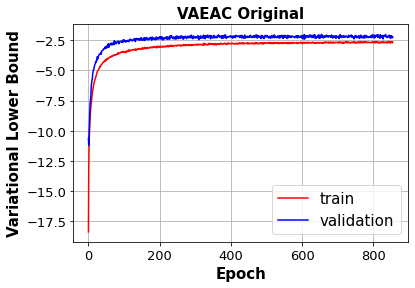

In [20]:

np.save("./torch_vlb/" + str(dname) + "_vlb_train_lr_" + str(lr), vlb_train)
np.save("./torch_vlb/" + str(dname) + "_vlb_val_lr_" + str(lr), vlb_val)

# best_epoch = 321 (pos 320 in train_val)
#curr_epoch = 522

print("best vlb ", best_vlb)
print("best epoch ", best_epoch)
print("curr epoch", curr_epoch)

plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['train', 'validation'], fontsize =15)
plt.ylabel('Variational Lower Bound', fontweight='bold', fontsize =15)
plt.xlabel('Epoch', fontweight='bold', fontsize =15)
plt.yticks(fontsize = 13)
plt.xticks(fontsize=13)
plt.title('VAEAC Original', fontweight='bold', fontsize= 15)
plt.grid(True)
plt.savefig('./torch_vlb/' +  'torch_compas_vaeac' + '.png', bbox_inches="tight")

In [19]:
print("best vlb ", best_vlb)
print("best epoch ", best_epoch)
print("curr epoch", curr_epoch)

best vlb  -1.995376444557338
best epoch  655
curr epoch 856


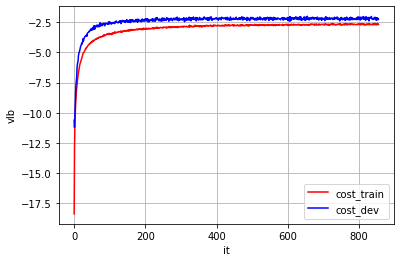

In [21]:
"""
plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_dev[:curr_epoch], -1000, 1000), 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('vlb')
plt.xlabel('it')
plt.grid(True)
plt.savefig( str(dname) + '_vlb_lr_' + str(lr) + '.png')
"""

## Credit

In [19]:
masker = top_masker(p=1)

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name='default_credit', splits=10, seed=42, separate_targets=False, save_dir='../data/')

input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2] #has this form for targets
print(input_dim_vec)

x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec)
x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec)

print(x_train.shape)
print(x_test.shape)

dname = 'default_credit'
print(dname)

trainset = Datafeed(x_train, x_train, transform=None)
valset = Datafeed(x_test, x_test, transform=None)

save_dir = '../saves/fc_preact_VAEAC_NEW2_' + dname

width = widths[names.index(dname)]
depth = depths[names.index(dname)] # number of hidden layers
latent_dim = latent_dims[names.index(dname)]

batch_size = 64
nb_epochs = 2000
early_stop = 200
lr = 7e-4

cuda = torch.cuda.is_available()

net = VAEAC_gauss_cat_net(input_dim_vec, width, depth, latent_dim, pred_sig=False, lr=lr, cuda=cuda, flatten=True)


vlb_train, vlb_dev = train_VAEAC(net, masker, save_dir, batch_size, nb_epochs, trainset, valset, cuda,
                     flat_ims=False, train_plot=False, Nclass=None, early_stop=early_stop)





[1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
(27000, 24)
(3000, 24)
default_credit

Net:
VAE_gauss_net
    Total params: 0.80M

Network:

Train:
  init cost variables:


/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_31096/1070947545.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


it 0/2000, vlb -19.182486,    time: 16.533756 seconds

    vlb -9.254449 (-inf)

Writting ../saves/fc_preact_VAEAC_NEW2_default_credit_models/theta_best.dat

it 1/2000, vlb -11.698959,    time: 18.969596 seconds

    vlb -7.840795 (-9.254449)

Writting ../saves/fc_preact_VAEAC_NEW2_default_credit_models/theta_best.dat

it 2/2000, vlb -10.394569,    time: 15.788894 seconds

    vlb -7.176111 (-7.840795)

Writting ../saves/fc_preact_VAEAC_NEW2_default_credit_models/theta_best.dat

it 3/2000, vlb -9.829430,    time: 17.466390 seconds

    vlb -6.881644 (-7.176111)

Writting ../saves/fc_preact_VAEAC_NEW2_default_credit_models/theta_best.dat

it 4/2000, vlb -9.581752,    time: 16.366702 seconds

    vlb -6.702829 (-6.881644)

Writting ../saves/fc_preact_VAEAC_NEW2_default_credit_models/theta_best.dat



KeyboardInterrupt: 

In [ ]:
print(net.model)

## Under VAEAC

In [21]:
class VAE_gauss(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim, pred_sig=True):
        super(VAE_gauss, self).__init__()

        self.encoder = MLP_preact_recognition_net(input_dim, width, depth, latent_dim)
        if pred_sig:
            self.decoder = MLP_preact_generator_net(2*input_dim, width, depth, latent_dim)
            self.rec_loglike = GaussianLoglike(min_sigma=1e-2)
        else:
            self.decoder = MLP_preact_generator_net(input_dim, width, depth, latent_dim)
            self.m_rec_loglike = MSELoss(reduction='none')
        self.pred_sig = pred_sig

    def encode(self, x):
        approx_post_params = self.encoder(x)
        approx_post = normal_parse_params(approx_post_params, 1e-3)
        return approx_post

    def decode(self, z_sample):
        rec_params = self.decoder(z_sample)
        return rec_params

    def vlb(self, prior, approx_post, x, rec_params):
        if self.pred_sig:
            rec = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        else:
            rec = -self.m_rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        kl = kl_divergence(approx_post, prior).view(x.shape[0], -1).sum(-1)
        return rec - kl

    def iwlb(self, prior, approx_post, x, K=50):
        estimates = []
        for i in range(K):
            latent = approx_post.rsample()
            rec_params = self.decode(latent)
            if self.pred_sig:
                rec_loglike = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
            else:
                rec_loglike = -self.m_rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)

            prior_log_prob = prior.log_prob(latent)
            prior_log_prob = prior_log_prob.view(x.shape[0], -1)
            prior_log_prob = prior_log_prob.sum(-1)

            proposal_log_prob = approx_post.log_prob(latent)
            proposal_log_prob = proposal_log_prob.view(x.shape[0], -1)
            proposal_log_prob = proposal_log_prob.sum(-1)

            estimate = rec_loglike + prior_log_prob - proposal_log_prob
            estimates.append(estimate[:, None])

        return torch.logsumexp(torch.cat(estimates, 1), 1) - np.log(K)


class VAE_gauss_net(BaseNet):
    def __init__(self, input_dim, width, depth, latent_dim, pred_sig=True, lr=1e-3, cuda=True):
        super(VAE_gauss_net, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.cuda = cuda

        self.input_dim = input_dim
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr
        self.pred_sig = pred_sig

        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.schedule = None

        if self.cuda:
            self.prior = self.prior = Normal(loc=torch.zeros(latent_dim).cuda(), scale=torch.ones(latent_dim).cuda())
        else:
            self.prior = Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim))
        self.vlb_scale = 1 / input_dim  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAE_gauss(self.input_dim, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = RAdam(self.model.parameters(), lr=self.lr)

    def fit(self, x):
        self.set_mode_train(train=True)

        x, = to_variable(var=(x, ), cuda=self.cuda)
        self.optimizer.zero_grad()

        approx_post = self.model.encode(x)
        z_sample = approx_post.rsample()
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(self.prior, approx_post, x, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        return vlb.mean().item(), rec_params

    def eval(self, x, sample=False):
        self.set_mode_train(train=False)

        x, = to_variable(var=(x, ), cuda=self.cuda)
        approx_post = self.model.encode(x)
        if sample:
            z_sample = approx_post.sample()
        else:
            z_sample = approx_post.loc
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(self.prior, approx_post, x, rec_params)

        return vlb.mean().item(), rec_params

    def eval_iw(self, x, k=50):
        self.set_mode_train(train=False)
        x,  = to_variable(var=(x, ), cuda=self.cuda)

        approx_post = self.model.recognition_encode(x)

        iw_lb = self.model.iwlb(self.prior, approx_post, x, k)
        return iw_lb.mean().item()

    def recongnition(self, x, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not x.requires_grad:
                x.requires_grad = True
        else:
            x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)
        approx_post = self.model.encode(x)
        return approx_post

    def regenerate(self, z, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)
        if self.pred_sig:
            return normal_parse_params(out, 1e-2)
        else:
            return out

In [22]:
def train_VAE(net, name, batch_size, nb_epochs, trainset, valset, cuda, flat_ims=False,
              train_plot=False, Nclass=None, early_stop=None, script_mode=False):

    models_dir = name + '_models'
    results_dir = name + '_results'
    mkdir(models_dir)
    mkdir(results_dir)

    if cuda:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                                  num_workers=0)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                                num_workers=0)

    else:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                                  num_workers=0)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                                num_workers=0)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
    cprint('c', '\nNetwork:')

    epoch = 0

    ## ---------------------------------------------------------------------------------------------------------------------
    # train
    cprint('c', '\nTrain:')

    print('  init cost variables:')
    vlb_train = np.zeros(nb_epochs)
    vlb_dev = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_vlb_train = -np.inf
    best_epoch = 0

    nb_its_dev = 1

    tic0 = time.time()
    i = 0
    for i in range(epoch, nb_epochs):
        net.set_mode_train(True)

        tic = time.time()
        nb_samples = 0
        for x, y in trainloader:

            if flat_ims:
                x = x.view(x.shape[0], -1)
            if Nclass is not None:
                y_oh = torch_onehot(y, Nclass).type(x.type())
                x = torch.cat([x, y_oh], 1)

            cost, _ = net.fit(x)

            vlb_train[i] += cost * len(x)
            nb_samples += len(x)

        vlb_train[i] /= nb_samples

        toc = time.time()

        # ---- print
        print("it %d/%d, vlb %f, " % (i, nb_epochs, vlb_train[i]), end="")
        cprint('r', '   time: %f seconds\n' % (toc - tic))
        net.update_lr(i)

        if vlb_train[i] > best_vlb_train:
            best_vlb_train = vlb_train[i]

        # ---- dev
        if i % nb_its_dev == 0:
            nb_samples = 0
            for j, (x, y) in enumerate(valloader):

                if flat_ims:
                    x = x.view(x.shape[0], -1)
                if Nclass is not None:
                    y_oh = torch_onehot(y, Nclass).type(x.type())
                    x = torch.cat([x, y_oh], 1)

                cost, _ = net.eval(x)

                vlb_dev[i] += cost * len(x)
                nb_samples += len(x)

            vlb_dev[i] /= nb_samples

            cprint('g', '    vlb %f (%f)\n' % (vlb_dev[i], best_vlb))

            if train_plot:
                zz = net.recongnition(x).sample()
                o = net.regenerate(zz)
                try:
                    o = o.cpu()
                except:
                    o = o.loc.cpu()
                if len(x.shape) == 2:
                    side = int(np.sqrt(x.shape[1]))
                    x = x.view(-1, 1, side, side).data
                    o = o.view(-1, 1, side, side).data

                # save_image(torch.cat([x[:8], o[:8]]), results_dir + '/rec_%d.png' % i, nrow=8)
                import matplotlib.pyplot as plt
                plt.figure()
                dd = make_grid(torch.cat([x[:10], o[:10]]), nrow=10).numpy()
                plt.imshow(np.transpose(dd, (1, 2, 0)), interpolation='nearest')
                if script_mode:
                    plt.savefig(results_dir + '/rec%d.png' % i)
                else:
                    plt.show()

                z_sample = normal(loc=0.0, scale=1.0, size=(36, net.latent_dim))
                x_rec = net.regenerate(z_sample)
                try:
                    x_rec = x_rec.cpu()
                except:
                    x_rec = x_rec.loc.cpu()
                if len(x_rec.shape) == 2:
                    side = int(np.sqrt(x_rec.shape[1]))
                    x_rec = x_rec.view(-1, 1, side, side)
                plt.figure()
                dd = make_grid(x_rec, nrow=6).numpy()
                plt.imshow(np.transpose(dd, (1, 2, 0)), interpolation='nearest')
                if script_mode:
                    plt.savefig(results_dir + '/sample%d.png' % i)
                else:
                    plt.show()

        if vlb_dev[i] > best_vlb:
            best_vlb = vlb_dev[i]
            best_epoch = i
            #net.save(models_dir + '/theta_best.dat')

        if early_stop is not None and (i - best_epoch) > early_stop:
            break


    #net.save(models_dir + '/theta_last.dat')
    toc0 = time.time()
    runtime_per_it = (toc0 - tic0) / float(nb_epochs)
    cprint('r', '   average time: %f seconds\n' % runtime_per_it)

    ## ---------------------------------------------------------------------------------------------------------------------
    # results
    """
    cprint('c', '\nRESULTS:')
    nb_parameters = net.get_nb_parameters()
    best_cost_dev = best_vlb
    best_cost_train = best_vlb_train

    print('  best_vlb_dev: %f' % best_cost_dev)
    print('  best_vlb_train: %f' % best_cost_train)
    print('  nb_parameters: %d (%s)\n' % (nb_parameters, humansize(nb_parameters)))

    ## ---------------------------------------------------------------------------------------------------------------------
    # fig cost vs its
    if not train_plot:
        import matplotlib
        matplotlib.use('agg')
    import matplotlib.pyplot as plt
    if train_plot:
        plt.figure()
        plt.plot(np.clip(vlb_train, -1000, 1000), 'r')
        plt.plot(np.clip(vlb_dev[::nb_its_dev], -1000, 1000), 'b')
        plt.legend(['cost_train', 'cost_dev'])
        plt.ylabel('vlb')
        plt.xlabel('it')
        plt.grid(True)
        plt.savefig(results_dir+'/train_cost.png')
        if train_plot:
            plt.show()
    """
    return vlb_train, vlb_dev, best_epoch, best_vlb, i





In [23]:
class under_VAEAC(BaseNet):
    def __init__(self, base_VAE, width, depth, latent_dim, lr=1e-3, cuda=True):
        super(under_VAEAC, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.base_VAEAC = base_VAE
        self.pred_sig = False

        self.cuda = cuda

        self.input_dim = self.base_VAEAC.latent_dim
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr

        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.schedule = None

        if self.cuda:
            self.prior = self.prior = Normal(loc=torch.zeros(latent_dim).cuda(), scale=torch.ones(latent_dim).cuda())
        else:
            self.prior = Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim))
        self.vlb_scale = 1 / self.input_dim  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAE_gauss(self.input_dim, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def fit(self, x):
        self.set_mode_train(train=True)

        x, = to_variable(var=(x, ), cuda=self.cuda)
        self.optimizer.zero_grad()

        z_sample = self.base_VAEAC.recognition_encode(x).sample()
        approx_post = self.model.encode(z_sample)
        u_sample = approx_post.rsample()
        rec_params = self.model.decode(u_sample)

        vlb = self.model.vlb(self.prior, approx_post, z_sample, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        return vlb.mean().item(), rec_params

    def eval(self, x):

        self.set_mode_train(train=False)

        x, = to_variable(var=(x, ), cuda=self.cuda)
        z_sample = self.base_VAEAC.recognition_encode(x).sample()
        approx_post = self.model.encode(z_sample)
        u_sample = approx_post.rsample()
        rec_params = self.model.decode(u_sample)

        vlb = self.model.vlb(self.prior, approx_post, z_sample, rec_params)

        return vlb.mean().item(), rec_params

    def eval_iw(self, x, k=50):
        self.set_mode_train(train=False)
        x,  = to_variable(var=(x, ), cuda=self.cuda)
        z_sample = self.base_VAEAC.recognition_encode(x).sample()
        approx_post = self.model.recognition_encode(z_sample)

        iw_lb = self.model.iwlb(self.prior, approx_post, z_sample, k)
        return iw_lb.mean().item()

    def recongnition(self, x, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not x.requires_grad:
                x.requires_grad = True
        else:
            x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)
        approx_post = self.model.encode(x)
        return approx_post

    def regenerate(self, z, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)
        return out.data

    def u_recongnition(self, x, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not x.requires_grad:
                x.requires_grad = True
        else:
            x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)

        z = self.base_VAEAC.recognition_encode(x).loc
        approx_post = self.model.encode(z)
        return approx_post

    def u_mask_recongnition(self, x, mask, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not x.requires_grad:
                x.requires_grad = True
            mask, = to_variable(var=(mask, ), cuda=self.cuda)
        else:
            x, mask = to_variable(var=(x, mask), cuda=self.cuda)

        z = self.base_VAEAC.prior_encode(x, mask).loc
        approx_post = self.model.encode(z)
        return approx_post

    def u_regenerate(self, u, grad=False):
        self.set_mode_train(train=False)
        if grad:
            if not u.requires_grad:
                u.requires_grad = True
        else:
            u, = to_variable(var=(u,), volatile=True, cuda=self.cuda)

        z = self.model.decode(u)
        out = self.base_VAEAC.decode(z)
        if self.base_VAEAC.pred_sig:
            return normal_parse_params(out, 1e-2)
        else:
            return out.data

In [25]:
# Credit
"""
dname = 'default_credit'
print(dname)

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../data/')

input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2] #has this form for targets
print(input_dim_vec)

x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec)
x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec)

x_train_flat = gauss_cat_to_flat(torch.Tensor(x_train), input_dim_vec)
x_test_flat = gauss_cat_to_flat(torch.Tensor(x_test), input_dim_vec)


print(x_train_flat.shape)
print(x_test_flat.shape)

trainset = Datafeed(x_train_flat, x_train_flat, transform=None)
valset = Datafeed(x_test_flat, x_test_flat, transform=None)


width = widths[names.index(dname)]
depth = depths[names.index(dname)] # number of hidden layers
latent_dim = latent_dims[names.index(dname)]
lr = 1e-4

cuda = torch.cuda.is_available()

#base_network_wraper = VAEAC_gauss_cat_net(input_dim_vec, width, depth, latent_dim, pred_sig=False, lr=lr, cuda=cuda, flatten=True)
#base_network_wraper.load('../saves/fc_preact_VAEAC_NEW2_' + dname + '_models/theta_best.dat')

base_network = net.model
width = 150
depth = 2
latent_dim = under_latent_dims2[names.index(dname)]

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

"""

# COMPAS
#"""
x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)
print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)

dname = 'compas'
print(dname)

trainset = Datafeed(x_train, x_train, transform=None)
valset = Datafeed(x_test, x_test, transform=None)

width = 150
depth = 2
latent_dim = under_latent_dims[names.index(dname)]

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

cuda = False

#base_network_wraper = VAEAC_gauss_cat_net(input_dim_vec, width, depth, latent_dim, pred_sig=False, lr=lr, cuda=cuda, flatten=True)
#base_network_wraper.load('../saves/fc_preact_VAEAC_NEW_' + dname + '_models/theta_best.dat')

base_network = net.model

#VAEAC = VAEAC_gauss_cat_net(input_dim_vec, width, depth, latent_dim, pred_sig=False, lr=lr, cuda=cuda, flatten=flat_vaeac_bools[d_idx])
#VAEAC.load('../saves/fc_preact_VAEAC_NEW_' + dname + '_models/theta_best.dat')

#base_network = base_network_wraper.model

savedir = './torch_vlb/fc_VAEAC_NEW_under_' + dname  # remove the 2 to remove dimensionality reduction

cuda = torch.cuda.is_available()

under_VAEAC_net = under_VAEAC(base_network, width, depth, latent_dim, lr, cuda=cuda)

vlb_train, vlb_dev, best_epoch, best_vlb, curr_epoch = train_VAE(under_VAEAC_net, savedir,
                               batch_size, nb_epochs, trainset, valset, cuda=cuda,
                               flat_ims=False, train_plot=False, Nclass=None, early_stop=early_stop)


Compas (5554, 19) (618, 19)
[3 6 2 2 2 1 1 2]
compas

Net:
VAE_gauss_net
    Total params: 0.05M

Network:

Train:
  init cost variables:


C:\Users\mortimer\AppData\Local\Temp/ipykernel_22248/1070947545.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


it 0/2000, vlb -16.552909,    time: 0.395074 seconds

    vlb -13.125182 (-inf)

it 1/2000, vlb -11.521138,    time: 0.439851 seconds

    vlb -10.333074 (-13.125182)

it 2/2000, vlb -9.540297,    time: 0.381172 seconds

    vlb -8.538390 (-10.333074)

it 3/2000, vlb -8.522815,    time: 0.381980 seconds

    vlb -7.963790 (-8.538390)

it 4/2000, vlb -8.115296,    time: 0.402921 seconds

    vlb -7.601742 (-7.963790)

it 5/2000, vlb -7.811508,    time: 0.401987 seconds

    vlb -7.994112 (-7.601742)

it 6/2000, vlb -7.819426,    time: 0.386507 seconds

    vlb -7.426943 (-7.601742)

it 7/2000, vlb -7.728694,    time: 0.411934 seconds

    vlb -7.557994 (-7.426943)

it 8/2000, vlb -7.512555,    time: 0.385640 seconds

    vlb -7.320632 (-7.426943)

it 9/2000, vlb -7.544233,    time: 0.402277 seconds

    vlb -7.062811 (-7.320632)

it 10/2000, vlb -7.437240,    time: 0.409840 seconds

    vlb -7.406143 (-7.062811)

it 11/2000, vlb -7.417204,    time: 0.393978 seconds

    vlb -7.213525 (-

it 80/2000, vlb -6.473291,    time: 0.380642 seconds

    vlb -6.231806 (-6.168288)

it 81/2000, vlb -6.386450,    time: 0.393340 seconds

    vlb -6.284911 (-6.168288)

it 82/2000, vlb -6.471514,    time: 0.415109 seconds

    vlb -6.351651 (-6.168288)

it 83/2000, vlb -6.398108,    time: 0.404891 seconds

    vlb -6.361766 (-6.168288)

it 84/2000, vlb -6.409984,    time: 0.378587 seconds

    vlb -6.253311 (-6.168288)

it 85/2000, vlb -6.472214,    time: 0.387001 seconds

    vlb -6.142238 (-6.168288)

it 86/2000, vlb -6.500485,    time: 0.393407 seconds

    vlb -6.310709 (-6.142238)

it 87/2000, vlb -6.443244,    time: 0.392277 seconds

    vlb -6.206509 (-6.142238)

it 88/2000, vlb -6.431979,    time: 0.391954 seconds

    vlb -6.260895 (-6.142238)

it 89/2000, vlb -6.426457,    time: 0.387619 seconds

    vlb -6.168997 (-6.142238)

it 90/2000, vlb -6.472029,    time: 0.379095 seconds

    vlb -6.236875 (-6.142238)

it 91/2000, vlb -6.448637,    time: 0.379656 seconds

    vlb -6.

it 159/2000, vlb -6.401927,    time: 0.418896 seconds

    vlb -6.223312 (-6.104055)

it 160/2000, vlb -6.393282,    time: 0.397519 seconds

    vlb -6.289355 (-6.104055)

it 161/2000, vlb -6.371887,    time: 0.370357 seconds

    vlb -6.202980 (-6.104055)

it 162/2000, vlb -6.346342,    time: 0.402110 seconds

    vlb -6.243317 (-6.104055)

it 163/2000, vlb -6.413532,    time: 0.373903 seconds

    vlb -6.352031 (-6.104055)

it 164/2000, vlb -6.375266,    time: 0.394070 seconds

    vlb -6.286810 (-6.104055)

it 165/2000, vlb -6.395371,    time: 0.384570 seconds

    vlb -6.279281 (-6.104055)

it 166/2000, vlb -6.443645,    time: 0.379833 seconds

    vlb -6.256909 (-6.104055)

it 167/2000, vlb -6.383839,    time: 0.424783 seconds

    vlb -6.160509 (-6.104055)

it 168/2000, vlb -6.364690,    time: 0.417272 seconds

    vlb -6.263319 (-6.104055)

it 169/2000, vlb -6.395268,    time: 0.386472 seconds

    vlb -6.280783 (-6.104055)

it 170/2000, vlb -6.359037,    time: 0.390060 seconds


it 238/2000, vlb -6.343128,    time: 0.380256 seconds

    vlb -6.114589 (-6.015011)

it 239/2000, vlb -6.356722,    time: 0.392980 seconds

    vlb -6.149192 (-6.015011)

it 240/2000, vlb -6.351412,    time: 0.420211 seconds

    vlb -6.104270 (-6.015011)

it 241/2000, vlb -6.393960,    time: 0.403611 seconds

    vlb -6.233919 (-6.015011)

it 242/2000, vlb -6.368896,    time: 0.387712 seconds

    vlb -6.113433 (-6.015011)

it 243/2000, vlb -6.347166,    time: 0.398816 seconds

    vlb -6.105509 (-6.015011)

it 244/2000, vlb -6.328558,    time: 0.415889 seconds

    vlb -6.390550 (-6.015011)

it 245/2000, vlb -6.358860,    time: 0.407058 seconds

    vlb -6.256924 (-6.015011)

it 246/2000, vlb -6.391318,    time: 0.394818 seconds

    vlb -6.109604 (-6.015011)

it 247/2000, vlb -6.410911,    time: 0.381304 seconds

    vlb -6.171204 (-6.015011)

it 248/2000, vlb -6.345385,    time: 0.377602 seconds

    vlb -6.259896 (-6.015011)

it 249/2000, vlb -6.341314,    time: 0.384977 seconds


it 317/2000, vlb -6.298844,    time: 0.416886 seconds

    vlb -6.169161 (-5.985919)

it 318/2000, vlb -6.355716,    time: 0.433840 seconds

    vlb -6.295353 (-5.985919)

it 319/2000, vlb -6.294968,    time: 0.388863 seconds

    vlb -6.254072 (-5.985919)

it 320/2000, vlb -6.300523,    time: 0.372594 seconds

    vlb -6.125876 (-5.985919)

it 321/2000, vlb -6.360593,    time: 0.365350 seconds

    vlb -6.196890 (-5.985919)

it 322/2000, vlb -6.369689,    time: 0.391980 seconds

    vlb -6.195996 (-5.985919)

it 323/2000, vlb -6.339726,    time: 0.361067 seconds

    vlb -6.193942 (-5.985919)

it 324/2000, vlb -6.336729,    time: 0.376097 seconds

    vlb -6.255024 (-5.985919)

it 325/2000, vlb -6.325942,    time: 0.376993 seconds

    vlb -6.106762 (-5.985919)

it 326/2000, vlb -6.329658,    time: 0.392950 seconds

    vlb -6.235408 (-5.985919)

it 327/2000, vlb -6.338459,    time: 0.420706 seconds

    vlb -6.144817 (-5.985919)

it 328/2000, vlb -6.316151,    time: 0.404135 seconds


it 396/2000, vlb -6.337680,    time: 0.392287 seconds

    vlb -6.201905 (-5.985919)

it 397/2000, vlb -6.356670,    time: 0.396938 seconds

    vlb -6.068730 (-5.985919)

it 398/2000, vlb -6.299813,    time: 0.389664 seconds

    vlb -6.153541 (-5.985919)

it 399/2000, vlb -6.339164,    time: 0.403922 seconds

    vlb -6.101538 (-5.985919)

it 400/2000, vlb -6.286968,    time: 0.380425 seconds

    vlb -6.198867 (-5.985919)

it 401/2000, vlb -6.300365,    time: 0.396438 seconds

    vlb -6.205887 (-5.985919)

it 402/2000, vlb -6.366295,    time: 0.393799 seconds

    vlb -6.207232 (-5.985919)

it 403/2000, vlb -6.311619,    time: 0.390012 seconds

    vlb -6.112798 (-5.985919)

it 404/2000, vlb -6.337098,    time: 0.398120 seconds

    vlb -6.247663 (-5.985919)

it 405/2000, vlb -6.348216,    time: 0.392493 seconds

    vlb -6.125947 (-5.985919)

it 406/2000, vlb -6.381601,    time: 0.407861 seconds

    vlb -6.179163 (-5.985919)

it 407/2000, vlb -6.305793,    time: 0.382572 seconds


it 475/2000, vlb -6.266431,    time: 0.376988 seconds

    vlb -6.075492 (-5.944186)

it 476/2000, vlb -6.302665,    time: 0.364635 seconds

    vlb -6.074968 (-5.944186)

it 477/2000, vlb -6.326942,    time: 0.381737 seconds

    vlb -6.208656 (-5.944186)

it 478/2000, vlb -6.353093,    time: 0.380991 seconds

    vlb -6.146125 (-5.944186)

it 479/2000, vlb -6.354736,    time: 0.418498 seconds

    vlb -6.063373 (-5.944186)

it 480/2000, vlb -6.315715,    time: 0.399220 seconds

    vlb -6.159573 (-5.944186)

it 481/2000, vlb -6.312483,    time: 0.364000 seconds

    vlb -6.246387 (-5.944186)

it 482/2000, vlb -6.286203,    time: 0.403903 seconds

    vlb -6.357959 (-5.944186)

it 483/2000, vlb -6.338617,    time: 0.378731 seconds

    vlb -6.099934 (-5.944186)

it 484/2000, vlb -6.325305,    time: 0.358737 seconds

    vlb -6.113967 (-5.944186)

it 485/2000, vlb -6.308981,    time: 0.388527 seconds

    vlb -6.190396 (-5.944186)

it 486/2000, vlb -6.316736,    time: 0.390979 seconds


it 554/2000, vlb -6.296418,    time: 0.368608 seconds

    vlb -6.103982 (-5.944186)

it 555/2000, vlb -6.364489,    time: 0.383630 seconds

    vlb -6.214694 (-5.944186)

it 556/2000, vlb -6.344497,    time: 0.380013 seconds

    vlb -6.153323 (-5.944186)

it 557/2000, vlb -6.259218,    time: 0.366991 seconds

    vlb -6.135377 (-5.944186)

it 558/2000, vlb -6.297971,    time: 0.393235 seconds

    vlb -6.062052 (-5.944186)

it 559/2000, vlb -6.328966,    time: 0.378282 seconds

    vlb -6.218480 (-5.944186)

it 560/2000, vlb -6.294514,    time: 0.379635 seconds

    vlb -6.272411 (-5.944186)

it 561/2000, vlb -6.332949,    time: 0.376925 seconds

    vlb -6.228172 (-5.944186)

it 562/2000, vlb -6.280023,    time: 0.376023 seconds

    vlb -6.140863 (-5.944186)

it 563/2000, vlb -6.320916,    time: 0.387816 seconds

    vlb -6.172093 (-5.944186)

it 564/2000, vlb -6.290190,    time: 0.368666 seconds

    vlb -6.217259 (-5.944186)

it 565/2000, vlb -6.272964,    time: 0.382601 seconds


it 633/2000, vlb -6.289485,    time: 0.376577 seconds

    vlb -6.143195 (-5.944186)

it 634/2000, vlb -6.299899,    time: 0.376743 seconds

    vlb -6.130884 (-5.944186)

it 635/2000, vlb -6.300354,    time: 0.383073 seconds

    vlb -6.119686 (-5.944186)

it 636/2000, vlb -6.329898,    time: 0.372152 seconds

    vlb -6.023461 (-5.944186)

it 637/2000, vlb -6.285444,    time: 0.385941 seconds

    vlb -6.202297 (-5.944186)

it 638/2000, vlb -6.342248,    time: 0.370718 seconds

    vlb -6.142872 (-5.944186)

it 639/2000, vlb -6.258252,    time: 0.378566 seconds

    vlb -6.187391 (-5.944186)

it 640/2000, vlb -6.317720,    time: 0.382976 seconds

    vlb -6.137143 (-5.944186)

it 641/2000, vlb -6.268360,    time: 0.371034 seconds

    vlb -6.156444 (-5.944186)

it 642/2000, vlb -6.365222,    time: 0.389587 seconds

    vlb -6.207402 (-5.944186)

it 643/2000, vlb -6.310038,    time: 0.367078 seconds

    vlb -6.070249 (-5.944186)

it 644/2000, vlb -6.288770,    time: 0.369845 seconds


best vlb  -5.944185536270388
best epoch  456
curr epoch 657


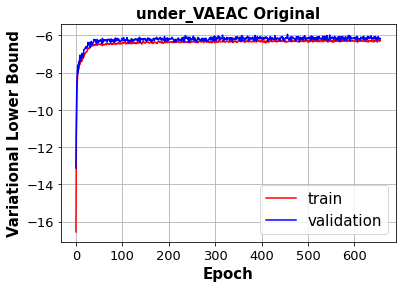

In [29]:

np.save("./torch_vlb/" + str(dname) + "_under_vlb_train_lr_" + str(lr), vlb_train)
np.save("./torch_vlb/" + str(dname) + "_under_vlb_val_lr_" + str(lr), vlb_dev)

# best_epoch = 321 (pos 320 in train_val)
#curr_epoch = 522

print("best vlb ", best_vlb)
print("best epoch ", best_epoch)
print("curr epoch", curr_epoch)

plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_dev[:curr_epoch], -1000, 1000), 'b')
plt.legend(['train', 'validation'], fontsize =15)
plt.ylabel('Variational Lower Bound', fontweight='bold', fontsize =15)
plt.xlabel('Epoch', fontweight='bold', fontsize =15)
plt.yticks(fontsize = 13)
plt.xticks(fontsize=13)
plt.title('under_VAEAC Original', fontweight='bold', fontsize= 15)
plt.grid(True)
plt.savefig('./torch_vlb/' +  'torch_compas_under_vaeac' + '.png', bbox_inches="tight")

In [26]:
print("best vlb ", best_vlb)
print("best epoch ", best_epoch)
print("curr epoch", curr_epoch)

best vlb  -5.8112255037795375
best epoch  316
curr epoch 517


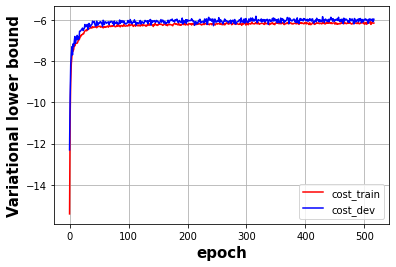

In [36]:
plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_dev[:curr_epoch], -1000, 1000), 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('Variational lower bound', fontweight ='bold', fontsize = 15)
plt.xlabel('epoch', fontweight ='bold', fontsize = 15)
plt.grid(True)
#plt.savefig( str(dname) + '_under_vlb_lr_' + str(lr) + '.png')

In [29]:
under_VAEAC_net.get_nb_parameters()

/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_10249/1070947545.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


49812

In [50]:
number_p = 0
for p in net.model.parameters():
    for i in range(len(p.data)):
        #print(len(p.data))
        try:
            number_p += len(p.data[i])
        except:
            number_p += 1
print(number_p)

778085


In [51]:
for p in net.model.parameters():
    print(p.data)

tensor([[ 0.1953,  0.1680, -0.0635,  ...,  0.1309,  0.0337, -0.1151],
        [ 0.0867, -0.1051, -0.0316,  ...,  0.1187,  0.0668,  0.1751],
        [ 0.0473, -0.1043,  0.0623,  ...,  0.0617,  0.0875,  0.0812],
        ...,
        [-0.1474,  0.2562, -0.1020,  ...,  0.1505,  0.1124,  0.0671],
        [-0.0777,  0.1288,  0.0823,  ...,  0.0869,  0.1883, -0.0504],
        [ 0.0840,  0.1529,  0.0006,  ...,  0.0037, -0.1448, -0.0819]])
tensor([-0.0420,  0.0951,  0.0312, -0.0081,  0.0587, -0.1466,  0.2107,  0.1487,
         0.1520, -0.1944,  0.2045,  0.0413, -0.2018,  0.2153, -0.0358,  0.0860,
         0.1789,  0.1633,  0.2059, -0.2002,  0.2350,  0.0600,  0.0048, -0.1823,
        -0.1383,  0.2303,  0.1632,  0.1677, -0.0273, -0.1063,  0.0492, -0.0949,
        -0.1412,  0.0960,  0.2115, -0.1593, -0.2120,  0.0359, -0.0733, -0.1013,
        -0.0405,  0.0021, -0.0675,  0.1887,  0.0983,  0.0666, -0.0523, -0.0020,
         0.1542,  0.0323, -0.2225,  0.0058,  0.0914, -0.0639, -0.0398, -0.0056,
      

In [53]:
for p in net.model.parameters():
    print(p.data)

tensor([[ 0.1953,  0.1680, -0.0635,  ...,  0.1309,  0.0337, -0.1151],
        [ 0.0867, -0.1051, -0.0316,  ...,  0.1187,  0.0668,  0.1751],
        [ 0.0473, -0.1043,  0.0623,  ...,  0.0617,  0.0875,  0.0812],
        ...,
        [-0.1474,  0.2562, -0.1020,  ...,  0.1505,  0.1124,  0.0671],
        [-0.0777,  0.1288,  0.0823,  ...,  0.0869,  0.1883, -0.0504],
        [ 0.0840,  0.1529,  0.0006,  ...,  0.0037, -0.1448, -0.0819]])
tensor([-0.0420,  0.0951,  0.0312, -0.0081,  0.0587, -0.1466,  0.2107,  0.1487,
         0.1520, -0.1944,  0.2045,  0.0413, -0.2018,  0.2153, -0.0358,  0.0860,
         0.1789,  0.1633,  0.2059, -0.2002,  0.2350,  0.0600,  0.0048, -0.1823,
        -0.1383,  0.2303,  0.1632,  0.1677, -0.0273, -0.1063,  0.0492, -0.0949,
        -0.1412,  0.0960,  0.2115, -0.1593, -0.2120,  0.0359, -0.0733, -0.1013,
        -0.0405,  0.0021, -0.0675,  0.1887,  0.0983,  0.0666, -0.0523, -0.0020,
         0.1542,  0.0323, -0.2225,  0.0058,  0.0914, -0.0639, -0.0398, -0.0056,
      